### Informasi Eksperimen
FLUENT - ICONNIC


DNN (non-cross val; param default) vs RNN (non-cross val; param default) + (2); (3); (4)

(2) evaluasi dengan BLEU (3) analisa dengan 5 prompt pertanyaan yang dispesifikasikan dan 5 prompt bebas dari user (4) menujukkan hasil evaluasi hasil prompt bebas dengan kategori buruk netral baik

Referensi tambahan:
https://www.researchgate.net/publication/336203630_Indonesian_Chatbot_of_University_Admission_Using_a_Question_Answering_System_Based_on_Sequence-to-Sequence_Model

In [46]:
import numpy as np
import tensorflow as tf
import pandas as pd
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras import preprocessing, utils
import os
import yaml

# Retrieve data train

In [47]:
knowledgebase = pd.read_excel('https://raw.githubusercontent.com/AndiAlifs/FLUENT-Chatbot-2023/main/KnowledgeBaseFilkom.xlsx', engine='openpyxl')
knowledgebase.head()

,No,Contributor,Topik/Tag,Pertanyaan,Jenis,Jawaban,Link Jawaban,Keterangan Tambahan
0,0.0,Fitra,Informasi Dosen,email Fitra A. Bachtiar,Statis,fitra.bachtiar[at]ub.ac.id,https://filkom.ub.ac.id/sdm-dosen/?search_f7a8...,NaN
1,NaN,NaN,NaN,NIK/NIP Fitra A. Bachtiar,Statis,198406282019031006,NaN,NaN
2,NaN,NaN,NaN,nama lengkap Fitra A. Bachtiar,Statis,Dr.Eng. Fitra A. Bachtiar,https://filkom.ub.ac.id/sdm-dosen/?search_f7a8...,NaN
3,NaN,NaN,NaN,Departemen Fitra A. Bachtiar,Dinamis,Departemen Teknik Informatika,https://filkom.ub.ac.id/sdm-dosen/?search_f7a8...,NaN
4,NaN,NaN,NaN,Program Studi Fitra A. Bachtiar,Dinamis,S2 Ilmu Komputer,https://filkom.ub.ac.id/sdm-dosen/?search_f7a8...,NaN


In [48]:
qa_paired = knowledgebase.drop(columns=knowledgebase.columns.drop(['Pertanyaan', 'Jawaban']))
qa_paired.dropna(inplace=True)
qa_paired

,Pertanyaan,Jawaban
0,email Fitra A. Bachtiar,fitra.bachtiar[at]ub.ac.id
1,NIK/NIP Fitra A. Bachtiar,198406282019031006
2,nama lengkap Fitra A. Bachtiar,Dr.Eng. Fitra A. Bachtiar
3,Departemen Fitra A. Bachtiar,Departemen Teknik Informatika
4,Program Studi Fitra A. Bachtiar,S2 Ilmu Komputer
...,...,...
1229,Apa Manfaat Konseling FILKOM ?,1. Masalah ditangani oleh ahli yang kompeten d...
1230,Berikan informasi mengenai Layanan Konseling,Informasi mengenai Layanan Konseling dapat dia...
1231,Siapa Konselor Bimbingan dan Konseling di FILK...,Ada 2 konselor Bimbingan dan Konseling di FILK...
1232,Siapa Koordinator Konselor Sebaya ?,Koordinator Konselor Sebaya adalah Muhammad Da...


# Implementasi RNN 

## Preprocessing Data

In [49]:
# remove all the punctuation from qa_paired
qa_paired['Pertanyaan'] = qa_paired['Pertanyaan'].str.replace('[^\w\s]',' ').str.lower()
qa_paired['Jawaban'] = qa_paired['Jawaban'].str.replace('[^\w\s]',' ').str.lower()

In [50]:
vocab = sorted(set(" ".join(qa_paired['Pertanyaan'] +" " + qa_paired['Jawaban']).split()))

In [51]:
questions = qa_paired['Pertanyaan']

answers = list()
for i in range( len(qa_paired['Jawaban']) ) :
    answers.append( '<START> ' + " ".join(qa_paired['Jawaban'].iloc[i].split()) + ' <END>' )

tokenizer = preprocessing.text.Tokenizer()
tokenizer.fit_on_texts( questions + answers )
VOCAB_SIZE = len( tokenizer.word_index )+1
print( 'VOCAB SIZE : {}'.format( VOCAB_SIZE ))

VOCAB SIZE : 2600


### Encoder-Decoder

In [52]:
from gensim.models import Word2Vec
import re

In [53]:
vocab = []
for word in tokenizer.word_index:
  vocab.append(word)

def tokenize(sentences):
  tokens_list = []
  vocabulary = []
  for sentence in sentences:
    sentence = sentence.lower()
    sentence = re.sub('[^a-zA-Z]', ' ', sentence)
    tokens = sentence.split()
    vocabulary += tokens
    tokens_list.append(tokens)
  return tokens_list, vocabulary

In [54]:
#encoder_input_data
tokenized_questions = tokenizer.texts_to_sequences( questions )
maxlen_questions = max( [len(x) for x in tokenized_questions ] )
padded_questions = preprocessing.sequence.pad_sequences( tokenized_questions, maxlen = maxlen_questions, padding = 'post')
encoder_input_data = np.array(padded_questions)
print(encoder_input_data.shape, maxlen_questions)

(1198, 13) 13


In [55]:
# decoder_input_data
tokenized_answers = tokenizer.texts_to_sequences( answers )
maxlen_answers = max( [ len(x) for x in tokenized_answers ] )
padded_answers = preprocessing.sequence.pad_sequences( tokenized_answers , maxlen=maxlen_answers , padding='post' )
decoder_input_data = np.array( padded_answers )
print( decoder_input_data.shape , maxlen_answers )

(1198, 294) 294


In [56]:
# decoder_output_data
tokenized_answers = tokenizer.texts_to_sequences( answers )
for i in range(len(tokenized_answers)) :
    tokenized_answers[i] = tokenized_answers[i][1:]
padded_answers = preprocessing.sequence.pad_sequences( tokenized_answers , maxlen=maxlen_answers , padding='post' )
onehot_answers = utils.to_categorical( padded_answers , VOCAB_SIZE )
decoder_output_data = np.array( onehot_answers )
print( decoder_output_data.shape )

(1198, 294, 2600)


## Modelling

In [57]:
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping

# define the checkpoint
checkpoint = ModelCheckpoint('riset/fluent/2023/model_alif/rnn_model_weights.h5', monitor='loss', verbose=1, save_best_only=True, mode='min')
earlystopping = EarlyStopping(monitor='loss', patience=5, verbose=1, mode='min')

In [58]:
# reset model
tf.keras.backend.clear_session()

In [122]:
encoder_inputs = tf.keras.layers.Input(shape=( maxlen_questions , ))
encoder_embedding = tf.keras.layers.Embedding( VOCAB_SIZE, 500 , mask_zero=True ) (encoder_inputs)
encoder_outputs , state_h , state_c = tf.keras.layers.LSTM( 500 , return_state=True )( encoder_embedding )
encoder_states = [ state_h , state_c ]

decoder_inputs = tf.keras.layers.Input(shape=( maxlen_answers ,  ))
decoder_embedding = tf.keras.layers.Embedding( VOCAB_SIZE, 500 , mask_zero=True) (decoder_inputs)
decoder_lstm = tf.keras.layers.LSTM( 500 , return_state=True , return_sequences=True )
decoder_outputs , _ , _ = decoder_lstm ( decoder_embedding , initial_state=encoder_states )
decoder_dense = tf.keras.layers.Dense( VOCAB_SIZE , activation=tf.keras.activations.softmax ) 
output = decoder_dense ( decoder_outputs )

model = tf.keras.models.Model([encoder_inputs, decoder_inputs], output )
model.compile(optimizer=tf.keras.optimizers.RMSprop(), loss='categorical_crossentropy')

model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 13)]         0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 294)]        0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 13, 500)      1300000     input_3[0][0]                    
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, 294, 500)     1300000     input_4[0][0]                    
____________________________________________________________________________________________

In [60]:
history = model.fit([encoder_input_data , decoder_input_data], 
                    decoder_output_data, 
                    batch_size=50, 
                    epochs=100,
                    callbacks=[checkpoint, 
                               earlystopping]) 

Epoch 1/100
24/24 [==============================] - 42s 1s/step - loss: 0.4441

Epoch 00001: loss improved from inf to 0.44414, saving model to riset/fluent/2023/model_alif/model_weights_Seq2Seq.h5
Epoch 2/100
24/24 [==============================] - 35s 1s/step - loss: 0.3895

Epoch 00002: loss improved from 0.44414 to 0.38950, saving model to riset/fluent/2023/model_alif/model_weights_Seq2Seq.h5
Epoch 3/100
24/24 [==============================] - 36s 1s/step - loss: 0.3575

Epoch 00003: loss improved from 0.38950 to 0.35755, saving model to riset/fluent/2023/model_alif/model_weights_Seq2Seq.h5
Epoch 4/100
24/24 [==============================] - 36s 1s/step - loss: 0.3320

Epoch 00004: loss improved from 0.35755 to 0.33197, saving model to riset/fluent/2023/model_alif/model_weights_Seq2Seq.h5
Epoch 5/100
24/24 [==============================] - 35s 1s/step - loss: 0.3098

Epoch 00005: loss improved from 0.33197 to 0.30979, saving model to riset/fluent/2023/model_alif/model_weights_

In [61]:
# load model best weights
model.load_weights('riset/fluent/2023/model_alif/rnn_model_weights.h5')

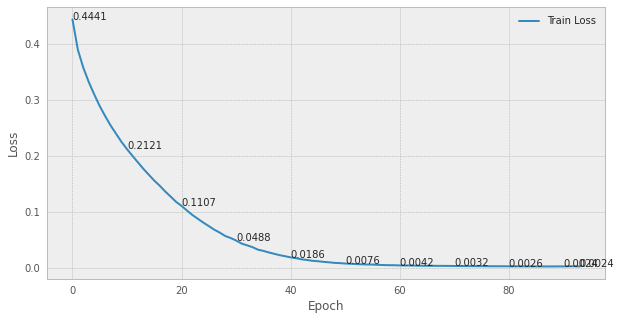

In [112]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 10
fig_size[1] = 5
# plt.title('Model CatCross Entropy Loss over Epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train Loss'], loc='upper right')

for i, loss in enumerate(history.history['loss']):
    # print("Epoch", i, ":", loss)
    if i % 10 == 0 or i == len(history.history['loss']) - 1:
        plt.annotate(str(round(loss, 4)), xy=(i,loss), xytext=(i,loss))
plt.show()


### Model Visualitation

## Test the chatbot

In [63]:
def make_inference_models():
    
    encoder_model = tf.keras.models.Model(encoder_inputs, encoder_states)
    
    decoder_state_input_h = tf.keras.layers.Input(shape=( 500 ,))
    decoder_state_input_c = tf.keras.layers.Input(shape=( 500 ,))
    
    decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
    
    decoder_outputs, state_h, state_c = decoder_lstm(
        decoder_embedding , initial_state=decoder_states_inputs)
    
    decoder_states = [state_h, state_c]

    decoder_outputs = decoder_dense(decoder_outputs)
    
    decoder_model = tf.keras.models.Model(
        [decoder_inputs] + decoder_states_inputs,
        [decoder_outputs] + decoder_states)
    
    return encoder_model , decoder_model

In [64]:
def str_to_tokens( sentence : str ):

    words = sentence.lower().split()
    tokens_list = list()

    for word in words:
        tokens_list.append( tokenizer.word_index[ word ] ) 
    return preprocessing.sequence.pad_sequences( [tokens_list] , maxlen=maxlen_questions , padding='post')


In [65]:
# disable warning tensorflow
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '5'

enc_model , dec_model = make_inference_models()

quest = input("Enter question : ")

states_values = enc_model.predict( str_to_tokens(quest) )
empty_target_seq = np.zeros( ( 1 , 1 ) )
empty_target_seq[0, 0] = tokenizer.word_index['start']
stop_condition = False
decoded_translation = ''
while not stop_condition :
    dec_outputs , h , c = dec_model.predict([ empty_target_seq ] + states_values )
    sampled_word_index = np.argmax( dec_outputs[0, -1, :] )
    sampled_word = None
    for word , index in tokenizer.word_index.items() :
        if sampled_word_index == index :
            decoded_translation += ' {}'.format( word )
            sampled_word = word
    
    if sampled_word == 'end' or len(decoded_translation.split()) > maxlen_answers:
        stop_condition = True
        
    empty_target_seq = np.zeros( ( 1 , 1 ) )  
    empty_target_seq[ 0 , 0 ] = sampled_word_index
    states_values = [ h , c ] 

print("Pertanyaan : ", quest.strip())
print("Jawaban : ", decoded_translation.strip())

Pertanyaan :  Email fitra
Jawaban :  tibyani at ub ac id end


# Implementasi DNN 

## Prepocessing Data

In [66]:
qa_paired_dnn = qa_paired
qa_paired_dnn['tag'] = qa_paired_dnn.index
qa_paired

,Pertanyaan,Jawaban,tag
0,email fitra a bachtiar,fitra bachtiar at ub ac id,0
1,nik nip fitra a bachtiar,198406282019031006,1
2,nama lengkap fitra a bachtiar,dr eng fitra a bachtiar,2
3,departemen fitra a bachtiar,departemen teknik informatika,3
4,program studi fitra a bachtiar,s2 ilmu komputer,4
...,...,...,...
1229,apa manfaat konseling filkom,1 masalah ditangani oleh ahli yang kompeten d...,1229
1230,berikan informasi mengenai layanan konseling,informasi mengenai layanan konseling dapat dia...,1230
1231,siapa konselor bimbingan dan konseling di filk...,ada 2 konselor bimbingan dan konseling di filk...,1231
1232,siapa koordinator konselor sebaya,koordinator konselor sebaya adalah muhammad da...,1232


In [67]:
X_train = qa_paired_dnn['Pertanyaan'].astype(str)

In [68]:
# tokenize Pertanyaan using tf 

tokenizer = Tokenizer(oov_token='x')
tokenizer.fit_on_texts(X_train)

doc_X = tokenizer.texts_to_sequences(X_train)
doc_X = pad_sequences(doc_X, maxlen=20, padding='post')

docs_Y = qa_paired_dnn['tag']
docs_Y = np.array(docs_Y).reshape(-1, 1)
encoder = OneHotEncoder(sparse=False)
doc_Y = encoder.fit_transform(docs_Y)

output_shape = len(doc_Y[0])

## Modelling

In [74]:
#deep learning model
model_dnn = Sequential()
model_dnn.add(Dense(4096, input_shape=(20,), activation="relu"))
model_dnn.add(Dense(4096, activation="relu"))
model_dnn.add(Dense(2048, activation="relu"))
model_dnn.add(Dense(output_shape, activation="sigmoid"))
model_dnn.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=["accuracy"])
print(model_dnn.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 4096)              86016     
_________________________________________________________________
dense_1 (Dense)              (None, 4096)              16781312  
_________________________________________________________________
dense_2 (Dense)              (None, 2048)              8390656   
_________________________________________________________________
dense_3 (Dense)              (None, 1198)              2454702   
Total params: 27,712,686
Trainable params: 27,712,686
Non-trainable params: 0
_________________________________________________________________
None


In [75]:
# reset model
tf.keras.backend.clear_session()

In [76]:
checkpoint = ModelCheckpoint('riset/fluent/2023/model_alif/dnn_model_weights.h5', monitor='accuracy', verbose=1, save_best_only=True, mode='max')
earlystopping = EarlyStopping(monitor='accuracy', patience=10, verbose=1, mode='max')

In [77]:
history_model_dnn = model_dnn.fit(x=doc_X, 
                       y=doc_Y,
                       epochs=500,
                       verbose=1,
                       callbacks=[checkpoint, 
                               earlystopping])

Epoch 1/500
38/38 [==============================] - 3s 74ms/step - loss: 20.7180 - accuracy: 0.0000e+00

Epoch 00001: accuracy improved from -inf to 0.00000, saving model to riset/fluent/2023/model_alif/dnn_model_weights.h5
Epoch 2/500
38/38 [==============================] - 3s 75ms/step - loss: 6.9585 - accuracy: 0.0025

Epoch 00002: accuracy improved from 0.00000 to 0.00250, saving model to riset/fluent/2023/model_alif/dnn_model_weights.h5
Epoch 3/500
38/38 [==============================] - 3s 74ms/step - loss: 6.1369 - accuracy: 0.0142

Epoch 00003: accuracy improved from 0.00250 to 0.01419, saving model to riset/fluent/2023/model_alif/dnn_model_weights.h5
Epoch 4/500
38/38 [==============================] - 3s 74ms/step - loss: 5.4797 - accuracy: 0.0301

Epoch 00004: accuracy improved from 0.01419 to 0.03005, saving model to riset/fluent/2023/model_alif/dnn_model_weights.h5
Epoch 5/500
38/38 [==============================] - 3s 74ms/step - loss: 5.0733 - accuracy: 0.0509

Epoch

In [73]:
model_dnn.load_weights('riset/fluent/2023/model_alif/dnn_model_weights.h5')

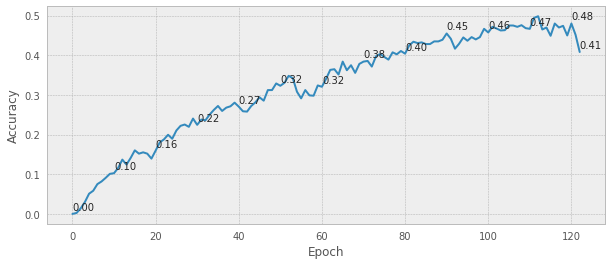

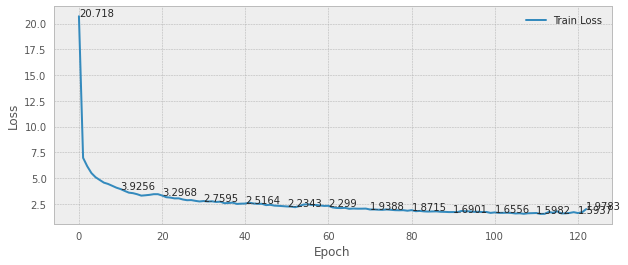

In [114]:
plt.plot(history_model_dnn.history['accuracy'])
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 10
fig_size[1] = 4
# plt.title('Model Accuracy over Epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')

for i, acc in enumerate(history_model_dnn.history['accuracy']):
    if i % 10 == 0 or i == len(history_model_dnn.history['accuracy']) - 1:
        plt.annotate('{:.2f}'.format(acc), xy=(i, acc), xytext=(i, acc + 0.01))

plt.show()

plt.plot(history_model_dnn.history['loss'])
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 10
fig_size[1] = 4
# plt.title('Model CatCross Entropy Loss over Epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train Loss'], loc='upper right')

for i, loss in enumerate(history_model_dnn.history['loss']):
    # print("Epoch", i, ":", loss)
    if i % 10 == 0 or i == len(history_model_dnn.history['loss']) - 1:
        plt.annotate(str(round(loss, 4)), xy=(i,loss), xytext=(i,loss))
plt.show()

# Comparison Model

In [103]:
history_dnn = {
    'accuracy': history_model_dnn.history['accuracy'],
    'loss': history_model_dnn.history['loss']
}

history_rnn = {
    'loss': history.history['loss']
}

with open('riset/fluent/2023/model_alif/history_dnn_13923.yaml', 'w') as file:
    documents = yaml.dump(history_dnn, file)

with open('riset/fluent/2023/model_alif/history_rnn_13923.yaml', 'w') as file:
    documents = yaml.dump(history_rnn, file)

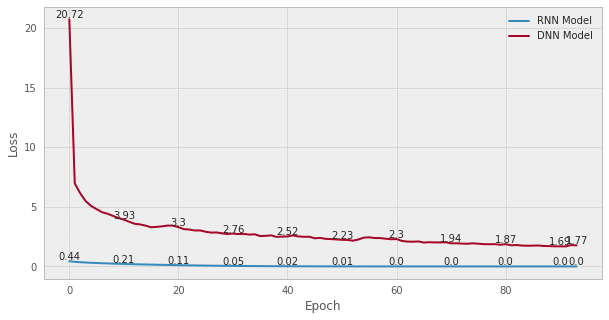

In [124]:
# remove whitegrid
plt.style.use('bmh')

fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 10
fig_size[1] = 5

loss_rnn = history.history['loss'][:94]
loss_dnn = history_model_dnn.history['loss'][:94]

plt.ylabel('Loss')
plt.xlabel('Epoch')

plt.plot(loss_rnn, label='RNN Model')
plt.plot(loss_dnn, label='DNN Model')
plt.legend()

# Add value labels for every 20 epochs
for i, loss in enumerate(loss_rnn):
    if i % 10 == 0 or i == 93:
        plt.annotate(str(round(loss, 2)), xy=(i, loss), xytext=(i, loss+0.1), ha='center')

for i, loss in enumerate(loss_dnn):
    if i % 10 == 0 or i == 93:
        plt.annotate(str(round(loss, 2)), xy=(i, loss), xytext=(i, loss+0.1), ha='center')

plt.show()